Same Data loading Code from linear&fnn code from Checkpoint Final.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [ ]:
# Clean data path
clean_path = "/content/drive/MyDrive/Colab Notebooks/retail_forecasting_sequences"

X_train_clean = np.load(f"{clean_path}/X_train_reshaped.npy")
y_train_clean = np.load(f"{clean_path}/y_train_reshaped.npy")
X_val_clean   = np.load(f"{clean_path}/X_val_reshaped.npy")
y_val_clean   = np.load(f"{clean_path}/y_val_reshaped.npy")
X_test_clean  = np.load(f"{clean_path}/X_test_reshaped.npy")
y_test_clean  = np.load(f"{clean_path}/y_test_reshaped.npy")

print("CLEAN DATA")
print("Train:", X_train_clean.shape, y_train_clean.shape)
print("Val:  ", X_val_clean.shape, y_val_clean.shape)
print("Test: ", X_test_clean.shape, y_test_clean.shape)

# Noisy data path
noisy_path = f"{clean_path}/retail_forecasting_sequences_noisy"

X_train_noisy = np.load(f"{noisy_path}/X_train_noisy_reshaped.npy")
y_train_noisy = np.load(f"{noisy_path}/y_train_noisy_reshaped.npy")
X_val_noisy   = np.load(f"{noisy_path}/X_val_noisy_reshaped.npy")
y_val_noisy   = np.load(f"{noisy_path}/y_val_noisy_reshaped.npy")
X_test_noisy  = np.load(f"{noisy_path}/X_test_noisy_reshaped.npy")
y_test_noisy  = np.load(f"{noisy_path}/y_test_noisy_reshaped.npy")

print("\n NOISY DATA")
print("Train:", X_train_noisy.shape, y_train_noisy.shape)
print("Val:  ", X_val_noisy.shape, y_val_noisy.shape)
print("Test: ", X_test_noisy.shape, y_test_noisy.shape)


CLEAN DATA
Train: (202883, 12, 19) (202883, 6, 19)
Val:   (43475, 12, 19) (43475, 6, 19)
Test:  (43475, 12, 19) (43475, 6, 19)

 NOISY DATA
Train: (202883, 12, 19) (202883, 6, 19)
Val:   (43474, 12, 19) (43474, 6, 19)
Test:  (43476, 12, 19) (43476, 6, 19)


In [ ]:
train_loader_clean = get_loaders(X_train_clean, y_train_clean)
val_loader_clean   = get_loaders(X_val_clean, y_val_clean)
test_loader_clean  = get_loaders(X_test_clean, y_test_clean)

train_loader_noisy = get_loaders(X_train_noisy, y_train_noisy)
val_loader_noisy   = get_loaders(X_val_noisy, y_val_noisy)
test_loader_noisy  = get_loaders(X_test_noisy, y_test_noisy)


The Basice Structure is from our Checkpoint

In [ ]:
import torch
import torch.nn as nn

class LSTM_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, output_seq_len):
        super(LSTM_Autoencoder, self).__init__()
        self.output_seq_len = output_seq_len

        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder: input shape (batch_size, seq_len, input_dim)
        _, (hidden, cell) = self.encoder(x)

        # Decoder input: repeat last hidden state across output_seq_len steps
        decoder_input = hidden[-1].unsqueeze(1).repeat(1, self.output_seq_len, 1)

        # Decoder: use repeated hidden state and original encoder hidden/cell
        decoded_output, _ = self.decoder(decoder_input, (hidden, cell))

        # Project to output dimension at each timestep
        output = self.output_layer(decoded_output)
        return output


Hyperparameter settings

In [ ]:
input_dim = X_train_clean.shape[2]
output_dim = y_train_clean.shape[2]
output_seq_len = y_train_clean.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter sets: (hidden_dim, num_layers, dropout, learning_rate)
hyperparams_list = [
    (64, 1, 0.1, 0.001),
    (128, 1, 0.2, 0.001),
    (128, 2, 0.3, 0.0005),
    (256, 2, 0.3, 0.0003),
    (64, 3, 0.5, 0.0001),
]

results_lstm = []

for data_mode in ['clean', 'noisy']:
    # Select dataset
    if data_mode == 'clean':
        train_loader, val_loader, test_loader = train_loader_clean, val_loader_clean, test_loader_clean
        y_test = y_test_clean
    else:
        train_loader, val_loader, test_loader = train_loader_noisy, val_loader_noisy, test_loader_noisy
        y_test = y_test_noisy

    for i, (hidden_dim, num_layers, dropout, lr) in enumerate(hyperparams_list, 1):
        print(f"Training [{data_mode.upper()}] LSTM Set {i} — hidden={hidden_dim}, layers={num_layers}, dropout={dropout}, lr={lr}")

        model = LSTM_Autoencoder(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            output_seq_len=output_seq_len
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        trained_model, train_losses, val_losses = train_lstm_model(
            model, train_loader, val_loader, epochs=20,
            criterion=criterion, optimizer=optimizer
        )

        # Test prediction
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
                output = model(x_batch)
                preds.append(output.cpu().numpy())
                targets.append(y_batch.cpu().numpy())

        preds = np.concatenate(preds, axis=0).reshape(-1, output_dim)
        targets = np.concatenate(targets, axis=0).reshape(-1, output_dim)

        # Metrics
        mse = mean_squared_error(targets, preds)
        mae = mean_absolute_error(targets, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(targets, preds)

        # Save results
        results_lstm.append({
            "data_mode": data_mode,
            "set": i,
            "hidden_dim": hidden_dim,
            "num_layers": num_layers,
            "dropout": dropout,
            "lr": lr,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "test_mse": mse,
            "test_mae": mae,
            "test_rmse": rmse,
            "test_r2": r2,
            "model": trained_model
        })


lstm_model = LSTM_Autoencoder(
    input_dim, hidden_dim, output_dim,
    num_layers, dropout, output_seq_len
).to(device)


Training [CLEAN] LSTM Set 1 — hidden=64, layers=1, dropout=0.1, lr=0.001
Epoch 1/20 | Train Loss: 0.0326 | Val Loss: 0.0561
Epoch 2/20 | Train Loss: 0.0267 | Val Loss: 0.0503
Epoch 3/20 | Train Loss: 0.0253 | Val Loss: 0.0476
Epoch 4/20 | Train Loss: 0.0244 | Val Loss: 0.0461
Epoch 5/20 | Train Loss: 0.0237 | Val Loss: 0.0452
Epoch 6/20 | Train Loss: 0.0232 | Val Loss: 0.0440
Epoch 7/20 | Train Loss: 0.0229 | Val Loss: 0.0430
Epoch 8/20 | Train Loss: 0.0227 | Val Loss: 0.0419
Epoch 9/20 | Train Loss: 0.0225 | Val Loss: 0.0403
Epoch 10/20 | Train Loss: 0.0222 | Val Loss: 0.0380
Epoch 11/20 | Train Loss: 0.0221 | Val Loss: 0.0362
Epoch 12/20 | Train Loss: 0.0219 | Val Loss: 0.0350
Epoch 13/20 | Train Loss: 0.0218 | Val Loss: 0.0344
Epoch 14/20 | Train Loss: 0.0217 | Val Loss: 0.0340
Epoch 15/20 | Train Loss: 0.0216 | Val Loss: 0.0336
Epoch 16/20 | Train Loss: 0.0216 | Val Loss: 0.0333
Epoch 17/20 | Train Loss: 0.0215 | Val Loss: 0.0330
Epoch 18/20 | Train Loss: 0.0215 | Val Loss: 0.0329


In [ ]:
from tabulate import tabulate

# Collect evaluation summary
summary = []
for res in results_lstm:
    row = [
        res["data_mode"].upper(),
        res["set"],
        res["hidden_dim"],
        res["num_layers"],
        res["dropout"],
        res["lr"],
        round(res["train_losses"][-1], 6),
        round(res["val_losses"][-1], 6),
        round(res["test_mse"], 6),
        round(res["test_mae"], 6),
        round(res["test_rmse"], 6),
        round(res["test_r2"], 6),
    ]
    summary.append(row)

# Table headers
headers = [
    "Data", "Set", "Hidden", "Layers", "Dropout", "LR",
    "Final Train Loss", "Final Val Loss",
    "Test MSE", "Test MAE", "Test RMSE", "Test R²"
]

# Print neatly
print(tabulate(summary, headers=headers, tablefmt="grid"))


+--------+-------+----------+----------+-----------+--------+--------------------+------------------+------------+------------+-------------+-----------+
| Data   |   Set |   Hidden |   Layers |   Dropout |     LR |   Final Train Loss |   Final Val Loss |   Test MSE |   Test MAE |   Test RMSE |   Test R² |
+========+=======+==========+==========+===========+========+====================+==================+============+============+=============+===========+
| CLEAN  |     1 |       64 |        1 |       0.1 | 0.001  |           0.021373 |         0.033359 |   0.031354 |   0.117842 |    0.177071 |  0.561091 |
+--------+-------+----------+----------+-----------+--------+--------------------+------------------+------------+------------+-------------+-----------+
| CLEAN  |     2 |      128 |        1 |       0.2 | 0.001  |           0.020756 |         0.031948 |   0.029914 |   0.111882 |    0.172955 |  0.579171 |
+--------+-------+----------+----------+-----------+--------+---------------

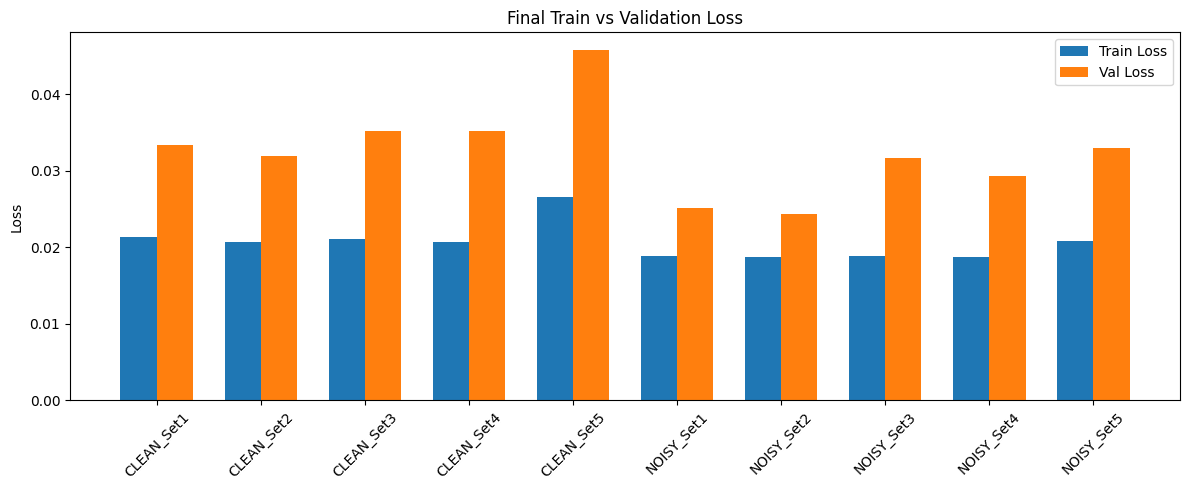

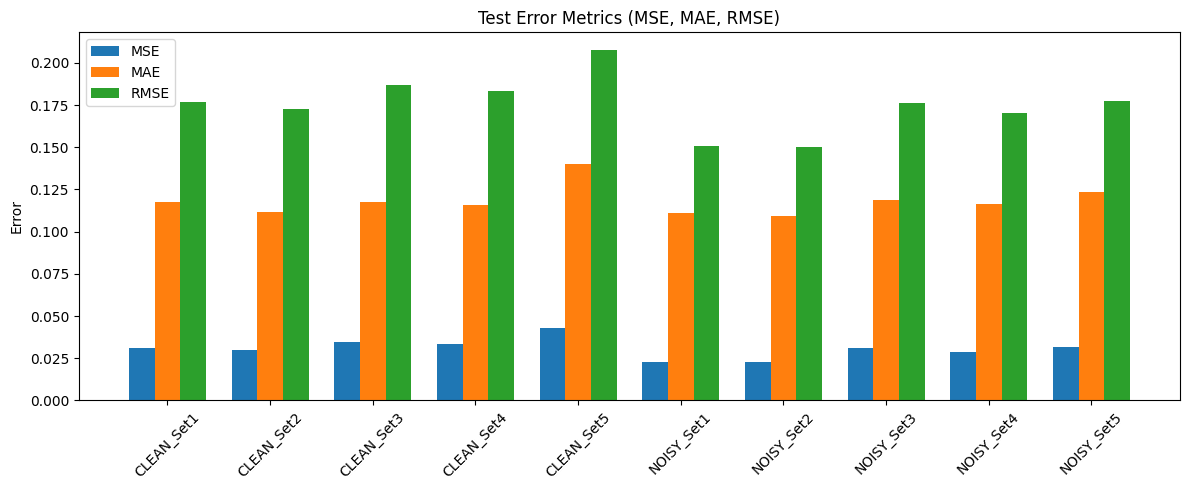

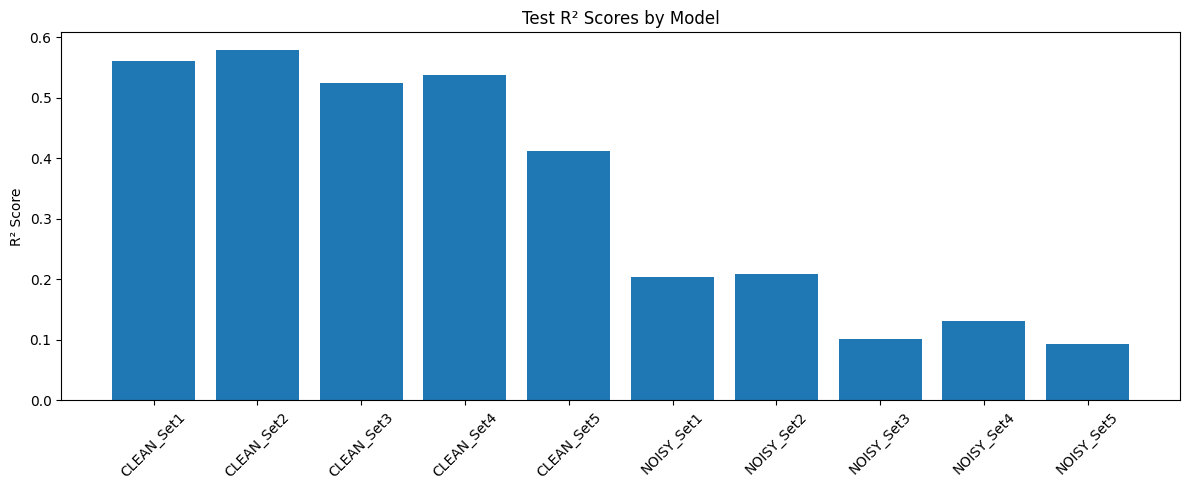

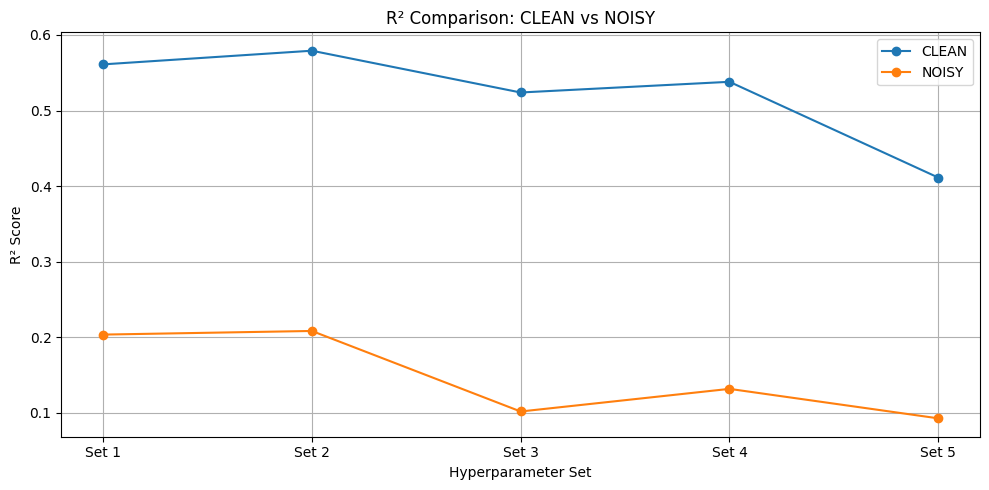

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to pandas DataFrame for easier plotting
import pandas as pd
df = pd.DataFrame(results_lstm)

# x-axis labels
df["Label"] = df["data_mode"].str.upper() + "_Set" + df["set"].astype(str)

# 1. Final Train & Val Loss
plt.figure(figsize=(12, 5))
x = np.arange(len(df))
bar_width = 0.35
plt.bar(x - bar_width/2, [l[-1] for l in df["train_losses"]], width=bar_width, label='Train Loss')
plt.bar(x + bar_width/2, [l[-1] for l in df["val_losses"]], width=bar_width, label='Val Loss')
plt.xticks(x, df["Label"], rotation=45)
plt.ylabel("Loss")
plt.title("Final Train vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Test MSE, MAE, RMSE
plt.figure(figsize=(12, 5))
x = np.arange(len(df))
bar_width = 0.25
plt.bar(x - bar_width, df["test_mse"], width=bar_width, label="MSE")
plt.bar(x, df["test_mae"], width=bar_width, label="MAE")
plt.bar(x + bar_width, df["test_rmse"], width=bar_width, label="RMSE")
plt.xticks(x, df["Label"], rotation=45)
plt.ylabel("Error")
plt.title("Test Error Metrics (MSE, MAE, RMSE)")
plt.legend()
plt.tight_layout()
plt.show()

# 3. R² scores
plt.figure(figsize=(12, 5))
plt.bar(df["Label"], df["test_r2"])
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("Test R² Scores by Model")
plt.tight_layout()
plt.show()

# 4. R²: Clean vs Noisy
plt.figure(figsize=(10, 5))
for mode in ["CLEAN", "NOISY"]:
    r2_vals = df[df["data_mode"] == mode.lower()]["test_r2"]
    plt.plot(range(1, 6), r2_vals, marker='o', label=mode)
plt.xticks(range(1, 6), [f"Set {i}" for i in range(1, 6)])
plt.xlabel("Hyperparameter Set")
plt.ylabel("R² Score")
plt.title("R² Comparison: CLEAN vs NOISY")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
save_dir = "saved_models/lstm"
os.makedirs(save_dir, exist_ok=True)

for res in results_lstm:
    data_mode = res["data_mode"]
    set_id = res["set"]
    model = res["model"]

    filename = f"lstm_{data_mode}_set{set_id}.pt"
    save_path = os.path.join(save_dir, filename)

    torch.save(model.state_dict(), save_path)

2. GRU Autoencoder(Code from Checkpoint)

In [ ]:
import torch
import torch.nn as nn

class GRU_Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout, output_seq_len):
        super(GRU_Autoencoder, self).__init__()
        self.output_seq_len = output_seq_len

        self.encoder = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.decoder = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Encoder
        _, hidden = self.encoder(x)

        # Decoder input: repeat last hidden state across output_seq_len steps
        decoder_input = hidden[-1].unsqueeze(1).repeat(1, self.output_seq_len, 1)

        # Decoder: use repeated hidden state and encoder output hidden state
        decoded_output, _ = self.decoder(decoder_input, hidden)

        # Project to output dim
        output = self.output_layer(decoded_output)
        return output


In [ ]:
input_dim = X_train_clean.shape[2]
output_dim = y_train_clean.shape[2]
output_seq_len = y_train_clean.shape[1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter sets: (hidden_dim, num_layers, dropout, learning_rate)
hyperparams_list = [
    (64, 1, 0.1, 0.001),
    (128, 1, 0.2, 0.001),
    (128, 2, 0.3, 0.0005),
    (256, 2, 0.3, 0.0003),
    (64, 3, 0.5, 0.0001),
]

results_gru = []

for data_mode in ['clean', 'noisy']:
    if data_mode == 'clean':
        train_loader, val_loader, test_loader = train_loader_clean, val_loader_clean, test_loader_clean
        y_test = y_test_clean
    else:
        train_loader, val_loader, test_loader = train_loader_noisy, val_loader_noisy, test_loader_noisy
        y_test = y_test_noisy

    for i, (hidden_dim, num_layers, dropout, lr) in enumerate(hyperparams_list, 1):
        print(f"Training [{data_mode.upper()}] GRU Set {i} — hidden={hidden_dim}, layers={num_layers}, dropout={dropout}, lr={lr}")

        model = GRU_Autoencoder(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            dropout=dropout,
            output_seq_len=output_seq_len
        ).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # GRU_train (using lstm again)
        trained_model, train_losses, val_losses = train_lstm_model(
            model, train_loader, val_loader, epochs=20,
            criterion=criterion, optimizer=optimizer
        )

        # Test prediction
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.float().to(device)
                output = model(x_batch)
                preds.append(output.cpu().numpy())
                targets.append(y_batch.cpu().numpy())

        preds = np.concatenate(preds, axis=0).reshape(-1, output_dim)
        targets = np.concatenate(targets, axis=0).reshape(-1, output_dim)

        # Metrics
        mse = mean_squared_error(targets, preds)
        mae = mean_absolute_error(targets, preds)
        rmse = np.sqrt(mse)
        r2 = r2_score(targets, preds)

        # Save results
        results_gru.append({
            "data_mode": data_mode,
            "set": i,
            "hidden_dim": hidden_dim,
            "num_layers": num_layers,
            "dropout": dropout,
            "lr": lr,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "test_mse": mse,
            "test_mae": mae,
            "test_rmse": rmse,
            "test_r2": r2,
            "model": trained_model
        })



Training [CLEAN] GRU Set 1 — hidden=64, layers=1, dropout=0.1, lr=0.001
Epoch 1/20 | Train Loss: 0.0315 | Val Loss: 0.0535
Epoch 2/20 | Train Loss: 0.0263 | Val Loss: 0.0499
Epoch 3/20 | Train Loss: 0.0246 | Val Loss: 0.0474
Epoch 4/20 | Train Loss: 0.0237 | Val Loss: 0.0455
Epoch 5/20 | Train Loss: 0.0232 | Val Loss: 0.0442
Epoch 6/20 | Train Loss: 0.0228 | Val Loss: 0.0430
Epoch 7/20 | Train Loss: 0.0225 | Val Loss: 0.0416
Epoch 8/20 | Train Loss: 0.0223 | Val Loss: 0.0399
Epoch 9/20 | Train Loss: 0.0222 | Val Loss: 0.0383
Epoch 10/20 | Train Loss: 0.0221 | Val Loss: 0.0366
Epoch 11/20 | Train Loss: 0.0219 | Val Loss: 0.0350
Epoch 12/20 | Train Loss: 0.0218 | Val Loss: 0.0336
Epoch 13/20 | Train Loss: 0.0217 | Val Loss: 0.0325
Epoch 14/20 | Train Loss: 0.0217 | Val Loss: 0.0316
Epoch 15/20 | Train Loss: 0.0216 | Val Loss: 0.0310
Epoch 16/20 | Train Loss: 0.0215 | Val Loss: 0.0306
Epoch 17/20 | Train Loss: 0.0215 | Val Loss: 0.0303
Epoch 18/20 | Train Loss: 0.0214 | Val Loss: 0.0302
E

In [ ]:
from tabulate import tabulate

# Collect evaluation summary
summary = []
for res in results_gru:
    row = [
        res["data_mode"].upper(),
        res["set"],
        res["hidden_dim"],
        res["num_layers"],
        res["dropout"],
        res["lr"],
        round(res["train_losses"][-1], 6),
        round(res["val_losses"][-1], 6),
        round(res["test_mse"], 6),
        round(res["test_mae"], 6),
        round(res["test_rmse"], 6),
        round(res["test_r2"], 6),
    ]
    summary.append(row)

# Table headers
headers = [
    "Data", "Set", "Hidden", "Layers", "Dropout", "LR",
    "Final Train Loss", "Final Val Loss",
    "Test MSE", "Test MAE", "Test RMSE", "Test R²"
]

# Print neatly
print(tabulate(summary, headers=headers, tablefmt="grid"))


+--------+-------+----------+----------+-----------+--------+--------------------+------------------+------------+------------+-------------+-----------+
| Data   |   Set |   Hidden |   Layers |   Dropout |     LR |   Final Train Loss |   Final Val Loss |   Test MSE |   Test MAE |   Test RMSE |   Test R² |
+========+=======+==========+==========+===========+========+====================+==================+============+============+=============+===========+
| CLEAN  |     1 |       64 |        1 |       0.1 | 0.001  |           0.02136  |         0.030481 |   0.027416 |   0.10977  |    0.165579 |  0.610336 |
+--------+-------+----------+----------+-----------+--------+--------------------+------------------+------------+------------+-------------+-----------+
| CLEAN  |     2 |      128 |        1 |       0.2 | 0.001  |           0.020719 |         0.030968 |   0.028301 |   0.110517 |    0.168229 |  0.599201 |
+--------+-------+----------+----------+-----------+--------+---------------

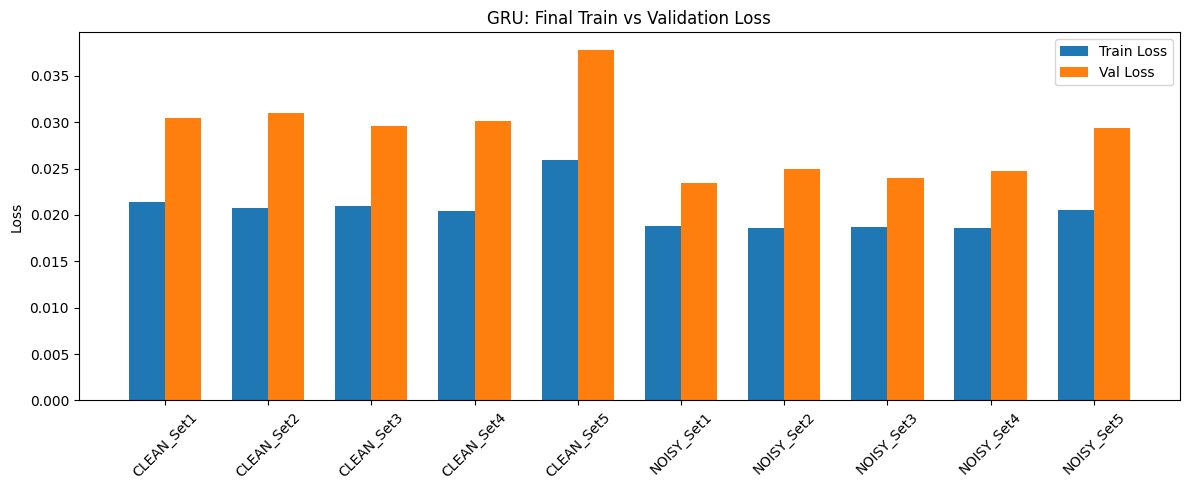

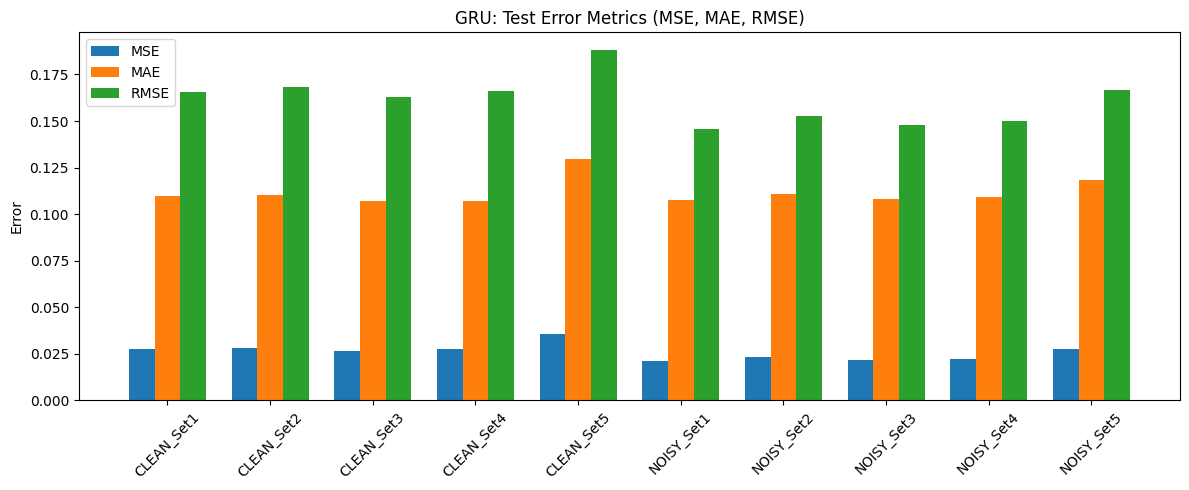

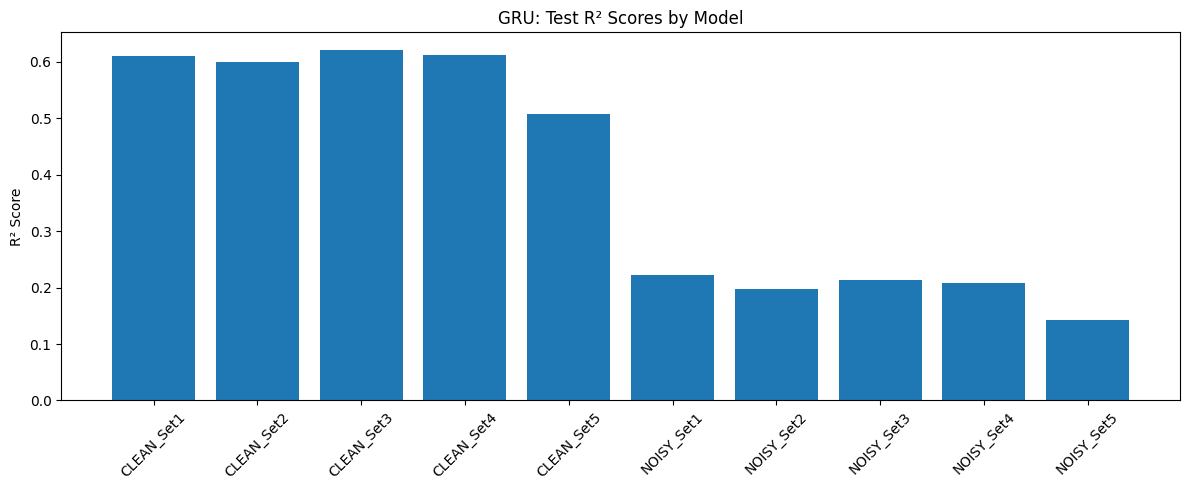

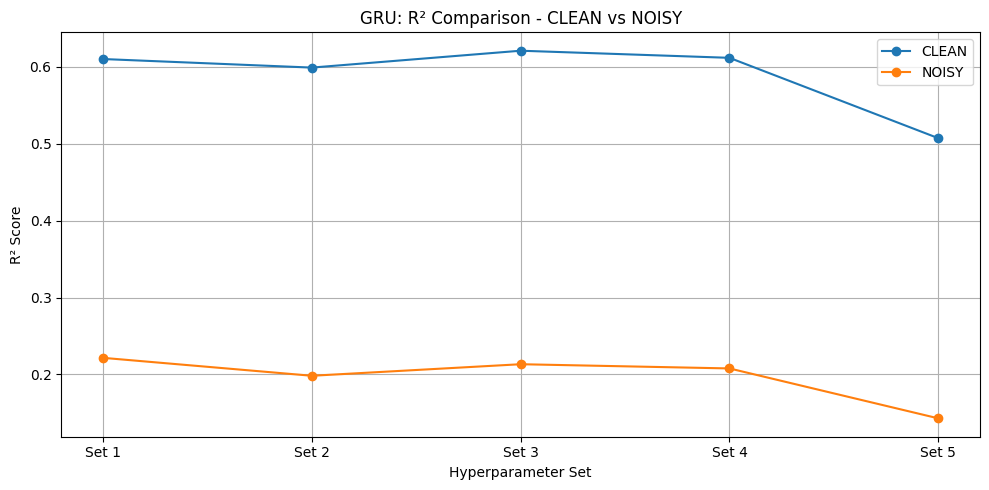

In [ ]:
df = pd.DataFrame(results_gru)

df["Label"] = df["data_mode"].str.upper() + "_Set" + df["set"].astype(str)

# 1. Final Train & Val Loss
plt.figure(figsize=(12, 5))
x = np.arange(len(df))
bar_width = 0.35
plt.bar(x - bar_width/2, [l[-1] for l in df["train_losses"]], width=bar_width, label='Train Loss')
plt.bar(x + bar_width/2, [l[-1] for l in df["val_losses"]], width=bar_width, label='Val Loss')
plt.xticks(x, df["Label"], rotation=45)
plt.ylabel("Loss")
plt.title("GRU: Final Train vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Test MSE, MAE, RMSE
plt.figure(figsize=(12, 5))
bar_width = 0.25
plt.bar(x - bar_width, df["test_mse"], width=bar_width, label="MSE")
plt.bar(x, df["test_mae"], width=bar_width, label="MAE")
plt.bar(x + bar_width, df["test_rmse"], width=bar_width, label="RMSE")
plt.xticks(x, df["Label"], rotation=45)
plt.ylabel("Error")
plt.title("GRU: Test Error Metrics (MSE, MAE, RMSE)")
plt.legend()
plt.tight_layout()
plt.show()

# 3. R² Scores
plt.figure(figsize=(12, 5))
plt.bar(df["Label"], df["test_r2"])
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("GRU: Test R² Scores by Model")
plt.tight_layout()
plt.show()

# 4. R²: Clean vs Noisy
plt.figure(figsize=(10, 5))
for mode in ["CLEAN", "NOISY"]:
    r2_vals = df[df["data_mode"] == mode.lower()]["test_r2"]
    plt.plot(range(1, 6), r2_vals, marker='o', label=mode)
plt.xticks(range(1, 6), [f"Set {i}" for i in range(1, 6)])
plt.xlabel("Hyperparameter Set")
plt.ylabel("R² Score")
plt.title("GRU: R² Comparison - CLEAN vs NOISY")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
save_dir = "saved_models/gru"
os.makedirs(save_dir, exist_ok=True)

for res in results_gru:
    data_mode = res["data_mode"]
    set_id = res["set"]
    model = res["model"]

    filename = f"gru_{data_mode}_set{set_id}.pt"
    save_path = os.path.join(save_dir, filename)

    torch.save(model.state_dict(), save_path)


In [ ]:
!zip -r saved_models.zip /content/saved_models
from google.colab import files
files.download('saved_models.zip')

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/gru/ (stored 0%)
  adding: content/saved_models/gru/gru_noisy_set2.pt (deflated 7%)
  adding: content/saved_models/gru/gru_noisy_set4.pt (deflated 7%)
  adding: content/saved_models/gru/gru_clean_set3.pt (deflated 7%)
  adding: content/saved_models/gru/gru_clean_set5.pt (deflated 8%)
  adding: content/saved_models/gru/gru_clean_set2.pt (deflated 7%)
  adding: content/saved_models/gru/gru_noisy_set5.pt (deflated 8%)
  adding: content/saved_models/gru/gru_clean_set4.pt (deflated 7%)
  adding: content/saved_models/gru/gru_noisy_set3.pt (deflated 7%)
  adding: content/saved_models/gru/gru_clean_set1.pt (deflated 8%)
  adding: content/saved_models/gru/gru_noisy_set1.pt (deflated 8%)
  adding: content/saved_models/lstm/ (stored 0%)
  adding: content/saved_models/lstm/lstm_clean_set2.pt (deflated 7%)
  adding: content/saved_models/lstm/lstm_noisy_set3.pt (deflated 7%)
  adding: content/saved_models/lstm/lstm_clean_set4

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
import pandas as pd

results_lstm = [
    {
        "data_mode": "clean",
        "set": 2,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.2,
        "lr": 0.001,
        "train_losses": [0.020756],
        "val_losses": [0.031948],
        "test_mse": 0.029914,
        "test_mae": 0.111882,
        "test_rmse": 0.172955,
        "test_r2": 0.579171,
        "model": None,
    },
    {
        "data_mode": "noisy",
        "set": 2,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.2,
        "lr": 0.001,
        "train_losses": [0.018703],
        "val_losses": [0.024432],
        "test_mse": 0.022538,
        "test_mae": 0.109349,
        "test_rmse": 0.150127,
        "test_r2": 0.208305,
        "model": None,
    }
]

results_gru = [
    {
        "data_mode": "clean",
        "set": 1,
        "hidden_dim": 128,
        "num_layers": 2,
        "dropout": 0.3,
        "lr": 0.0005,
        "train_losses": [0.02091],
        "val_losses": [0.029602],
        "test_mse": 0.026579,
        "test_mae": 0.106866,
        "test_rmse": 0.163029,
        "test_r2": 0.621158,
        "model": None,
    },
    {
        "data_mode": "noisy",
        "set": 1,
        "hidden_dim": 64,
        "num_layers": 1,
        "dropout": 0.1,
        "lr": 0.001,
        "train_losses": [0.018817],
        "val_losses": [0.023477],
        "test_mse": 0.021239,
        "test_mae": 0.10767,
        "test_rmse": 0.145736,
        "test_r2": 0.221615,
        "model": None,
    }
]

def build_summary(results, model_name):
    summary = []
    for res in results:
        row = [
            res["data_mode"].upper(),
            res["set"],
            res["hidden_dim"],
            res["num_layers"],
            res["dropout"],
            res["lr"],
            round(res["train_losses"][-1], 6),
            round(res["val_losses"][-1], 6),
            round(res["test_mse"], 6),
            round(res["test_mae"], 6),
            round(res["test_rmse"], 6),
            round(res["test_r2"], 6),
            model_name
        ]
        summary.append(row)
    return summary

headers = [
    "Data", "Set", "Hidden", "Layers", "Dropout", "LR",
    "Final Train Loss", "Final Val Loss",
    "Test MSE", "Test MAE", "Test RMSE", "Test R²", "Model"
]


lstm_summary = build_summary(results_lstm, "LSTM")
gru_summary = build_summary(results_gru, "GRU")


all_summary = lstm_summary + gru_summary
summary_df = pd.DataFrame(all_summary, columns=headers)


best_df = (
    summary_df.sort_values(by=["Model", "Data", "Test MSE", "Test R²"], ascending=[True, True, True, False])
    .groupby(["Model", "Data"])
    .first()
    .reset_index()
)

print (best_df)

  Model   Data  Set  Hidden  Layers  Dropout      LR  Final Train Loss  \
0   GRU  CLEAN    1     128       2      0.3  0.0005          0.020910   
1   GRU  NOISY    1      64       1      0.1  0.0010          0.018817   
2  LSTM  CLEAN    2     128       1      0.2  0.0010          0.020756   
3  LSTM  NOISY    2     128       1      0.2  0.0010          0.018703   

   Final Val Loss  Test MSE  Test MAE  Test RMSE   Test R²  
0        0.029602  0.026579  0.106866   0.163029  0.621158  
1        0.023477  0.021239  0.107670   0.145736  0.221615  
2        0.031948  0.029914  0.111882   0.172955  0.579171  
3        0.024432  0.022538  0.109349   0.150127  0.208305  


In [8]:
# Reconstructing comparison_df since it's not defined in this cell
import pandas as pd

# Original summary DataFrame
results_lstm = [
    {
        "data_mode": "clean",
        "set": 2,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.2,
        "lr": 0.001,
        "train_losses": [0.020756],
        "val_losses": [0.031948],
        "test_mse": 0.029914,
        "test_mae": 0.111882,
        "test_rmse": 0.172955,
        "test_r2": 0.579171,
        "model": None,
    },
    {
        "data_mode": "noisy",
        "set": 2,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.2,
        "lr": 0.001,
        "train_losses": [0.018703],
        "val_losses": [0.024432],
        "test_mse": 0.022538,
        "test_mae": 0.109349,
        "test_rmse": 0.150127,
        "test_r2": 0.208305,
        "model": None,
    }
]

results_gru = [
    {
        "data_mode": "clean",
        "set": 1,
        "hidden_dim": 128,
        "num_layers": 2,
        "dropout": 0.3,
        "lr": 0.0005,
        "train_losses": [0.02091],
        "val_losses": [0.029602],
        "test_mse": 0.026579,
        "test_mae": 0.106866,
        "test_rmse": 0.163029,
        "test_r2": 0.621158,
        "model": None,
    },
    {
        "data_mode": "noisy",
        "set": 1,
        "hidden_dim": 64,
        "num_layers": 1,
        "dropout": 0.1,
        "lr": 0.001,
        "train_losses": [0.018817],
        "val_losses": [0.023477],
        "test_mse": 0.021239,
        "test_mae": 0.10767,
        "test_rmse": 0.145736,
        "test_r2": 0.221615,
        "model": None,
    }
]

def build_summary(results, model_name):
    summary = []
    for res in results:
        row = [
            res["data_mode"].upper(),
            res["set"],
            res["hidden_dim"],
            res["num_layers"],
            res["dropout"],
            res["lr"],
            round(res["train_losses"][-1], 6),
            round(res["val_losses"][-1], 6),
            round(res["test_mse"], 6),
            round(res["test_mae"], 6),
            round(res["test_rmse"], 6),
            round(res["test_r2"], 6),
            model_name
        ]
        summary.append(row)
    return summary

headers = [
    "Data", "Set", "Hidden", "Layers", "Dropout", "LR",
    "Final Train Loss", "Final Val Loss",
    "Test MSE", "Test MAE", "Test RMSE", "Test R²", "Model"
]

lstm_summary = build_summary(results_lstm, "LSTM")
gru_summary = build_summary(results_gru, "GRU")
all_summary = lstm_summary + gru_summary
comparison_df = pd.DataFrame(all_summary, columns=headers)

# Now compare the GRU and LSTM again
comparison_summary = []

# Clean Data Comparison
clean_gru = comparison_df[(comparison_df["Model"] == "GRU") & (comparison_df["Data"] == "CLEAN")].iloc[0]
clean_lstm = comparison_df[(comparison_df["Model"] == "LSTM") & (comparison_df["Data"] == "CLEAN")].iloc[0]

comparison_summary.append({
    "Data": "CLEAN",
    "Better Model": "GRU" if clean_gru["Test R²"] > clean_lstm["Test R²"] else "LSTM",
    "GRU Test MSE": clean_gru["Test MSE"],
    "LSTM Test MSE": clean_lstm["Test MSE"],
    "GRU Test R²": clean_gru["Test R²"],
    "LSTM Test R²": clean_lstm["Test R²"]
})

# Noisy Data Comparison
noisy_gru = comparison_df[(comparison_df["Model"] == "GRU") & (comparison_df["Data"] == "NOISY")].iloc[0]
noisy_lstm = comparison_df[(comparison_df["Model"] == "LSTM") & (comparison_df["Data"] == "NOISY")].iloc[0]

comparison_summary.append({
    "Data": "NOISY",
    "Better Model": "GRU" if noisy_gru["Test R²"] > noisy_lstm["Test R²"] else "LSTM",
    "GRU Test MSE": noisy_gru["Test MSE"],
    "LSTM Test MSE": noisy_lstm["Test MSE"],
    "GRU Test R²": noisy_gru["Test R²"],
    "LSTM Test R²": noisy_lstm["Test R²"]
})

comparison_result_df = pd.DataFrame(comparison_summary)
print(comparison_result_df)


    Data Better Model  GRU Test MSE  LSTM Test MSE  GRU Test R²  LSTM Test R²
0  CLEAN          GRU      0.026579       0.029914     0.621158      0.579171
1  NOISY          GRU      0.021239       0.022538     0.221615      0.208305


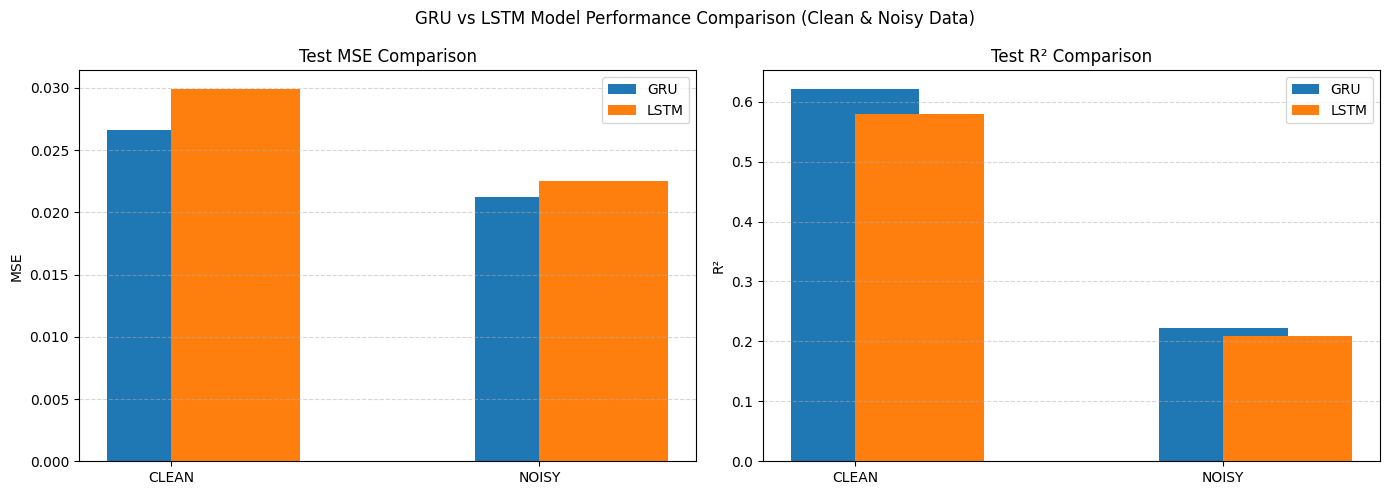

In [9]:
# Plotting GRU vs LSTM comparison
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

x = comparison_result_df["Data"]

# Plot Test MSE
axs[0].bar(x, comparison_result_df["GRU Test MSE"], width=0.35, label="GRU", align='center')
axs[0].bar(x, comparison_result_df["LSTM Test MSE"], width=0.35, label="LSTM", align='edge')
axs[0].set_title("Test MSE Comparison")
axs[0].set_ylabel("MSE")
axs[0].legend()
axs[0].grid(axis="y", linestyle="--", alpha=0.5)

# Plot Test R²
axs[1].bar(x, comparison_result_df["GRU Test R²"], width=0.35, label="GRU", align='center')
axs[1].bar(x, comparison_result_df["LSTM Test R²"], width=0.35, label="LSTM", align='edge')
axs[1].set_title("Test R² Comparison")
axs[1].set_ylabel("R²")
axs[1].legend()
axs[1].grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("GRU vs LSTM Model Performance Comparison (Clean & Noisy Data)")
plt.tight_layout()
plt.show()


In [2]:

def generate_model_name(row):
    return f"{row['Model']}_{row['Data']}_Set{row['Set']}_H{row['Hidden']}_L{row['Layers']}_D{row['Dropout']}_LR{row['LR']}"

best_df["Model_Name"] = best_df.apply(generate_model_name, axis=1)


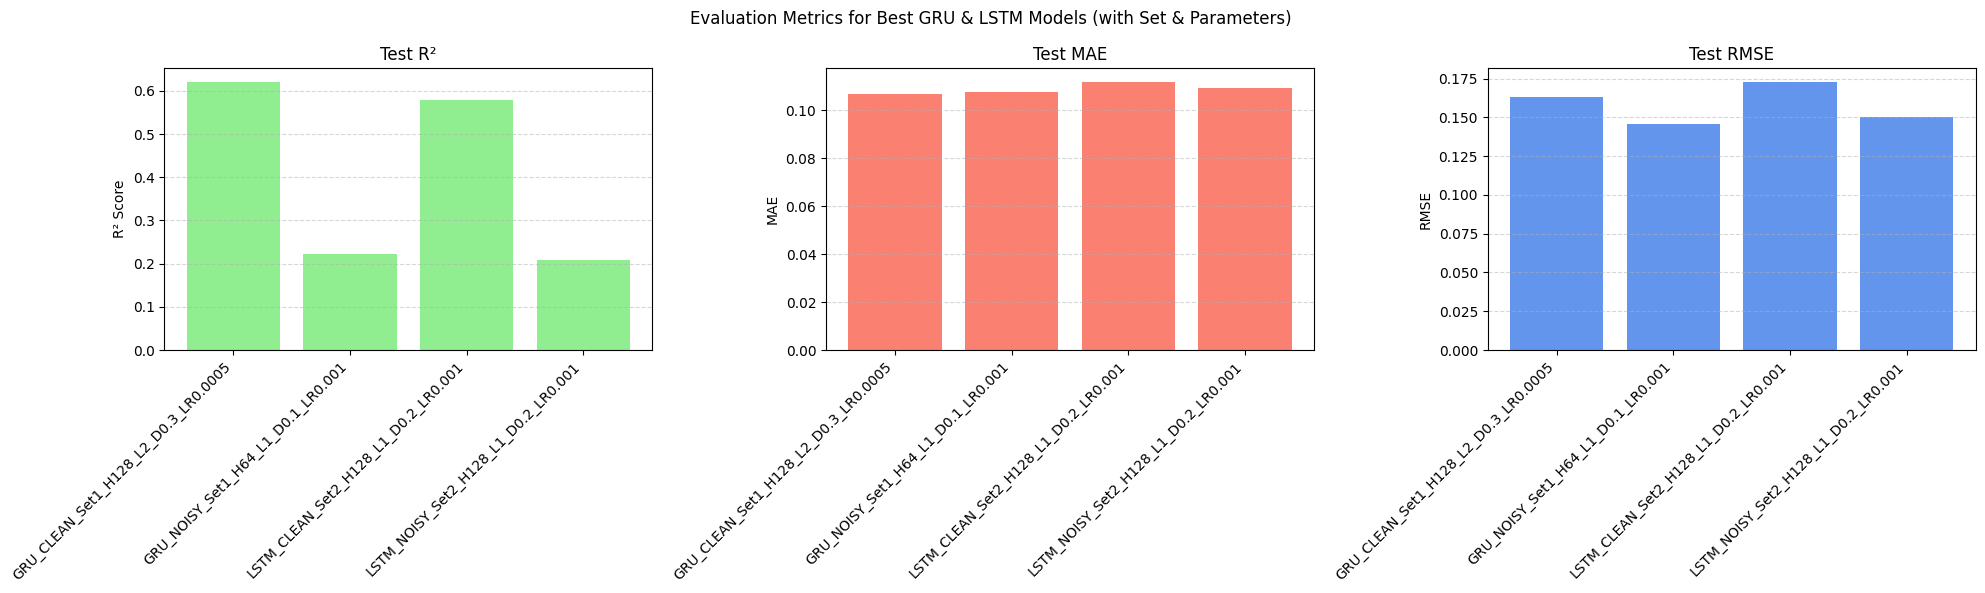

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

x_labels = best_df["Model_Name"].tolist()
x = range(len(x_labels))

axs[0].bar(x, best_df["Test R²"], color="lightgreen")
axs[0].set_title("Test R²")
axs[0].set_ylabel("R² Score")
axs[0].set_xticks(x)
axs[0].set_xticklabels(x_labels, rotation=45, ha="right")
axs[0].grid(axis="y", linestyle="--", alpha=0.5)

axs[1].bar(x, best_df["Test MAE"], color="salmon")
axs[1].set_title("Test MAE")
axs[1].set_ylabel("MAE")
axs[1].set_xticks(x)
axs[1].set_xticklabels(x_labels, rotation=45, ha="right")
axs[1].grid(axis="y", linestyle="--", alpha=0.5)

axs[2].bar(x, best_df["Test RMSE"], color="cornflowerblue")
axs[2].set_title("Test RMSE")
axs[2].set_ylabel("RMSE")
axs[2].set_xticks(x)
axs[2].set_xticklabels(x_labels, rotation=45, ha="right")
axs[2].grid(axis="y", linestyle="--", alpha=0.5)

plt.suptitle("Evaluation Metrics for Best GRU & LSTM Models (with Set & Parameters)")
plt.tight_layout()
plt.show()



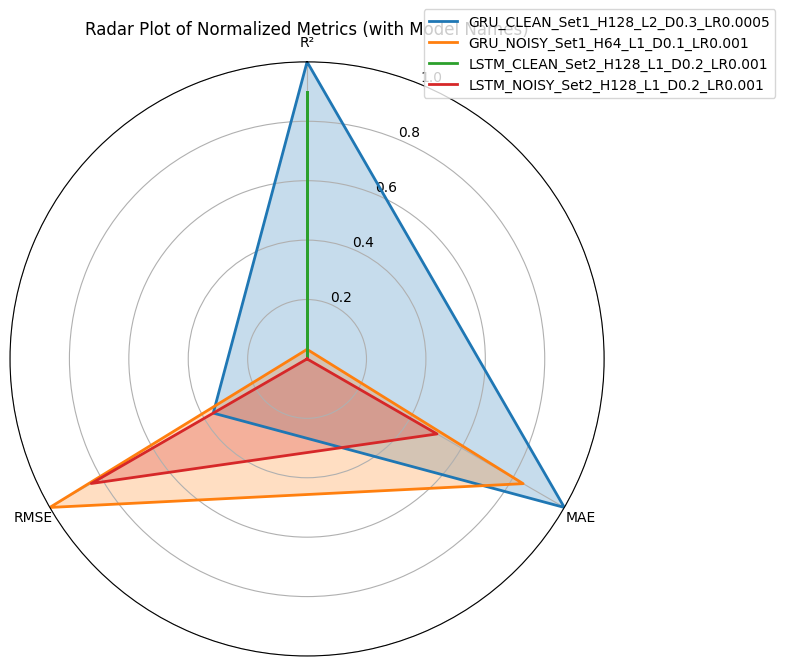

In [4]:
import numpy as np

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

normalized_df = best_df.copy()
normalized_df["Norm R²"] = normalize(best_df["Test R²"])
normalized_df["Norm MAE"] = 1 - normalize(best_df["Test MAE"])
normalized_df["Norm RMSE"] = 1 - normalize(best_df["Test RMSE"])

labels = ["R²", "MAE", "RMSE"]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for _, row in normalized_df.iterrows():
    values = [row["Norm R²"], row["Norm MAE"], row["Norm RMSE"]]
    values += values[:1]
    ax.plot(angles, values, label=row["Model_Name"], linewidth=2)
    ax.fill(angles, values, alpha=0.25)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_ylim(0, 1)
ax.set_title("Radar Plot of Normalized Metrics (with Model Names)", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


In [ ]:
import torch

base_clean = "/content/drive/MyDrive/retail_forecasting_sequences"
base_noisy = "/content/drive/MyDrive/retail_forecasting_sequences/retail_forecasting_sequences_noisy"

models = {
    "LSTM CLEAN": f"{base_clean}/lstm_clean_model.pt",
    "LSTM NOISY": f"{base_noisy}/lstm_noisy_model.pt",
    "GRU CLEAN": f"{base_clean}/gru_clean_model.pt",
    "GRU NOISY": f"{base_noisy}/gru_noisy_model_noisy.pt"  # corrected filename
}

for name, path in models.items():
    print(f"\n{name} — {path}")
    try:
        state_dict = torch.load(path)
        print(list(state_dict.keys()))
    except Exception as e:
        print(f"Error loading model: {e}")



LSTM CLEAN — /content/drive/MyDrive/retail_forecasting_sequences/lstm_clean_model.pt
['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias']

LSTM NOISY — /content/drive/MyDrive/retail_forecasting_sequences/retail_forecasting_sequences_noisy/lstm_noisy_model.pt
['lstm.weight_ih_l0', 'lstm.weight_hh_l0', 'lstm.bias_ih_l0', 'lstm.bias_hh_l0', 'lstm.weight_ih_l1', 'lstm.weight_hh_l1', 'lstm.bias_ih_l1', 'lstm.bias_hh_l1', 'fc.weight', 'fc.bias']

GRU CLEAN — /content/drive/MyDrive/retail_forecasting_sequences/gru_clean_model.pt
['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0', 'gru.weight_ih_l1', 'gru.weight_hh_l1', 'gru.bias_ih_l1', 'gru.bias_hh_l1', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias']

GRU NOISY — /content/drive/MyDrive/retail_forecasting_sequences/retail_forecasting_sequences_noisy/gru_noisy_model_noisy.pt
['gru.wei

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model definitions
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, output_dim):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                            dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class GRUWithTwoFC(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout, fc1_dim, output_dim):
        super(GRUWithTwoFC, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True,
                          dropout=dropout if num_layers > 1 else 0.0)
        self.fc1 = nn.Linear(hidden_dim, fc1_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc1_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.relu(self.fc1(out[:, -1, :]))
        return self.fc2(out)

# Paths
base_clean = "/content/drive/MyDrive/retail_forecasting_sequences"
base_noisy = "/content/drive/MyDrive/retail_forecasting_sequences/retail_forecasting_sequences_noisy"

# Model hyperparameters
input_dim = 19
hidden_dim = 128
num_layers = 2
dropout = 0.2
fc1_dim = 64
output_dim = 114  # 19 features × 6 months
output_seq_len = 6
num_features = 19

# Load test data
X_test_clean = np.load(f"{base_clean}/X_test_reshaped.npy")
y_test_clean = np.load(f"{base_clean}/y_test_reshaped.npy")
X_test_noisy = np.load(f"{base_noisy}/X_test_noisy_reshaped.npy")
y_test_noisy = np.load(f"{base_noisy}/y_test_noisy_reshaped.npy")

X_clean_tensor = torch.tensor(X_test_clean, dtype=torch.float32)
X_noisy_tensor = torch.tensor(X_test_noisy, dtype=torch.float32)

# Load models
models = {}

models["LSTM CLEAN"] = SimpleLSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)
models["LSTM CLEAN"].load_state_dict(torch.load(f"{base_clean}/lstm_clean_model.pt"))
models["LSTM CLEAN"].eval()

models["LSTM NOISY"] = SimpleLSTM(input_dim, hidden_dim, num_layers, dropout, output_dim)
models["LSTM NOISY"].load_state_dict(torch.load(f"{base_noisy}/lstm_noisy_model.pt"))
models["LSTM NOISY"].eval()

models["GRU CLEAN"] = GRUWithTwoFC(input_dim, hidden_dim, num_layers, dropout, fc1_dim, output_dim)
models["GRU CLEAN"].load_state_dict(torch.load(f"{base_clean}/gru_clean_model.pt"))
models["GRU CLEAN"].eval()

models["GRU NOISY"] = GRUWithTwoFC(input_dim, hidden_dim, num_layers, dropout, fc1_dim, output_dim)
models["GRU NOISY"].load_state_dict(torch.load(f"{base_noisy}/gru_noisy_model_noisy.pt"))
models["GRU NOISY"].eval()

# Run predictions
with torch.no_grad():
    preds = {
        "LSTM CLEAN": models["LSTM CLEAN"](X_clean_tensor).numpy(),
        "LSTM NOISY": models["LSTM NOISY"](X_noisy_tensor).numpy(),
        "GRU CLEAN": models["GRU CLEAN"](X_clean_tensor).numpy(),
        "GRU NOISY": models["GRU NOISY"](X_noisy_tensor).numpy()
    }

# Evaluation
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

print("=== Evaluation Results ===")
for name, pred in preds.items():
    true = y_test_clean if "CLEAN" in name else y_test_noisy
    true_flat = true.reshape(-1, num_features * output_seq_len)
    pred_flat = pred.reshape(-1, num_features * output_seq_len)
    mse, mae, r2 = evaluate(true_flat, pred_flat)
    print(f"{name} — MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


=== Evaluation Results ===
LSTM CLEAN — MSE: 0.0251, MAE: 0.0954, R²: 0.6392
LSTM NOISY — MSE: 0.0349, MAE: 0.1368, R²: -0.6686
GRU CLEAN — MSE: 0.0266, MAE: 0.1108, R²: 0.6157
GRU NOISY — MSE: 0.0198, MAE: 0.1002, R²: 0.2393


In [ ]:
import pandas as pd

df_y_clean = pd.read_csv("/content/drive/MyDrive/retail_forecasting_sequences/train_y.csv")
print(df_y_clean.columns.tolist())


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113']


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(y_test_clean, y_test_noisy, preds, output_seq_len=6, num_features=19):
    sample_idx = 0

    # --- BAR PLOT: Sample 0, Feature 0 ---
    feature = 0
    start = feature * output_seq_len
    end = (feature + 1) * output_seq_len

    actual_clean = y_test_clean[sample_idx, :, feature]
    actual_noisy = y_test_noisy[sample_idx, :, feature]

    pred_lstm_clean = preds["LSTM CLEAN"][sample_idx, start:end]
    pred_gru_clean = preds["GRU CLEAN"][sample_idx, start:end]
    pred_lstm_noisy = preds["LSTM NOISY"][sample_idx, start:end]
    pred_gru_noisy = preds["GRU NOISY"][sample_idx, start:end]

    x = np.arange(output_seq_len)
    bar_width = 0.18

    plt.figure(figsize=(14, 6))
    plt.bar(x - 2*bar_width, actual_clean, width=bar_width, label="Actual (Clean)")
    plt.bar(x - bar_width, pred_lstm_clean, width=bar_width, label="LSTM Clean")
    plt.bar(x, pred_gru_clean, width=bar_width, label="GRU Clean")
    plt.bar(x + bar_width, pred_lstm_noisy, width=bar_width, label="LSTM Noisy")
    plt.bar(x + 2*bar_width, pred_gru_noisy, width=bar_width, label="GRU Noisy")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Bar Plot – Sample {sample_idx}, Feature {feature}")
    plt.xticks(x)
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- LINE PLOTS: Features 0, 1, 2 ---
    for feature in range(3):
        start = feature * output_seq_len
        end = (feature + 1) * output_seq_len

        plt.figure(figsize=(10, 4))
        plt.plot(y_test_clean[sample_idx, :, feature], label="Actual (Clean)", marker='o')
        plt.plot(y_test_noisy[sample_idx, :, feature], label="Actual (Noisy)", marker='x')
        plt.plot(preds["LSTM CLEAN"][sample_idx, start:end], label="LSTM CLEAN", linestyle='--', linewidth=2)
        plt.plot(preds["GRU CLEAN"][sample_idx, start:end], label="GRU CLEAN", linestyle=':', linewidth=2)
        plt.plot(preds["LSTM NOISY"][sample_idx, start:end], label="LSTM NOISY", linestyle='--', alpha=0.6)
        plt.plot(preds["GRU NOISY"][sample_idx, start:end], label="GRU NOISY", linestyle=':', alpha=0.6)
        plt.title(f"Sample {sample_idx} – Feature {feature}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # --- SCATTER PLOT: Predicted vs Actual (Clean vs Noisy) ---
    plt.figure(figsize=(12, 10))
    true_flat_clean = y_test_clean.reshape(-1)
    true_flat_noisy = y_test_noisy.reshape(-1)

    models = [
        ("LSTM CLEAN", preds["LSTM CLEAN"].reshape(-1), true_flat_clean, "blue"),
        ("GRU CLEAN", preds["GRU CLEAN"].reshape(-1), true_flat_clean, "green"),
        ("LSTM NOISY", preds["LSTM NOISY"].reshape(-1), true_flat_noisy, "orange"),
        ("GRU NOISY", preds["GRU NOISY"].reshape(-1), true_flat_noisy, "red")
    ]

    for i, (name, pred, truth, color) in enumerate(models):
        plt.subplot(2, 2, i+1)
        plt.scatter(truth, pred, alpha=0.4, color=color, label=name)
        plt.plot([truth.min(), truth.max()], [truth.min(), truth.max()], 'k--')
        plt.title(f"{name} vs Actual")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- BOX PLOT: Prediction Error Distribution ---
    errors = {
        "LSTM CLEAN": (preds["LSTM CLEAN"] - y_test_clean.reshape(y_test_clean.shape[0], -1)).flatten(),
        "GRU CLEAN": (preds["GRU CLEAN"] - y_test_clean.reshape(y_test_clean.shape[0], -1)).flatten(),
        "LSTM NOISY": (preds["LSTM NOISY"] - y_test_noisy.reshape(y_test_noisy.shape[0], -1)).flatten(),
        "GRU NOISY": (preds["GRU NOISY"] - y_test_noisy.reshape(y_test_noisy.shape[0], -1)).flatten()
    }

    plt.figure(figsize=(10, 5))
    plt.boxplot(errors.values(), labels=errors.keys(), showmeans=True)
    plt.title("Prediction Error Distribution (Predicted - Actual)")
    plt.ylabel("Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


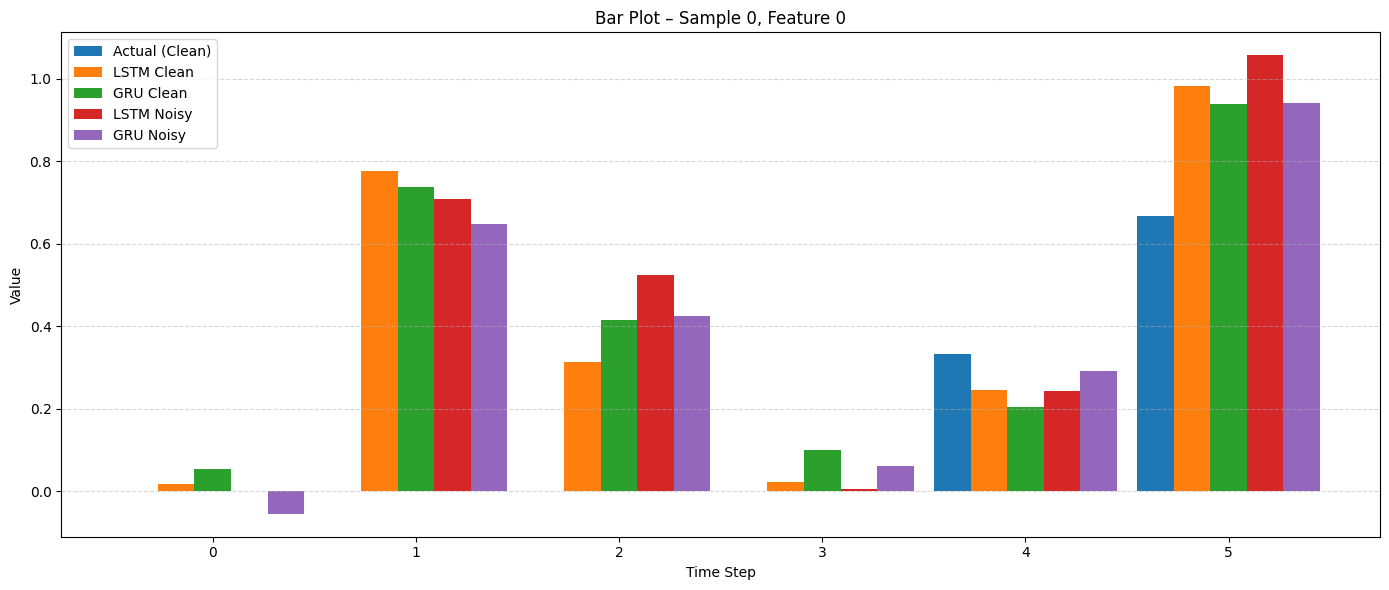

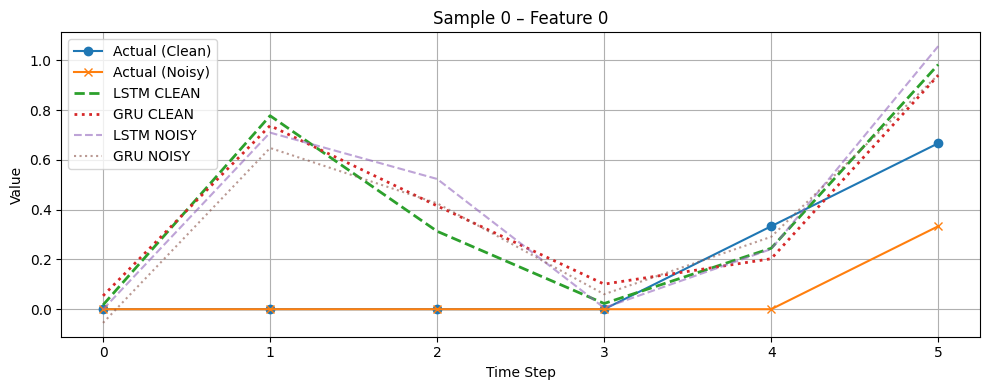

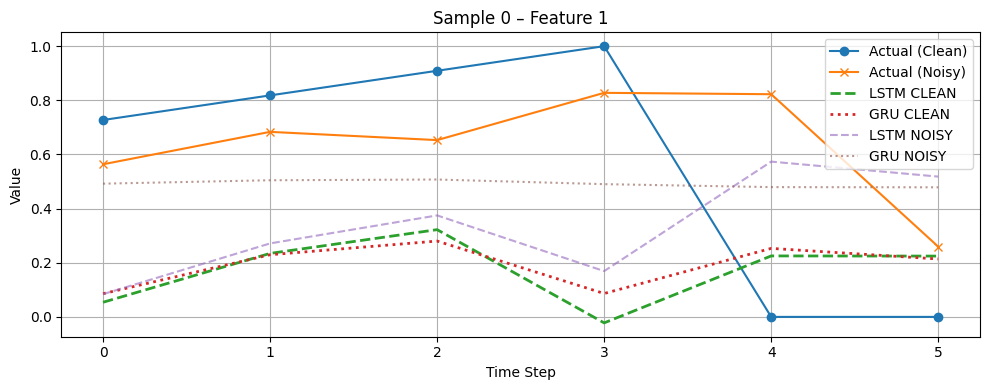

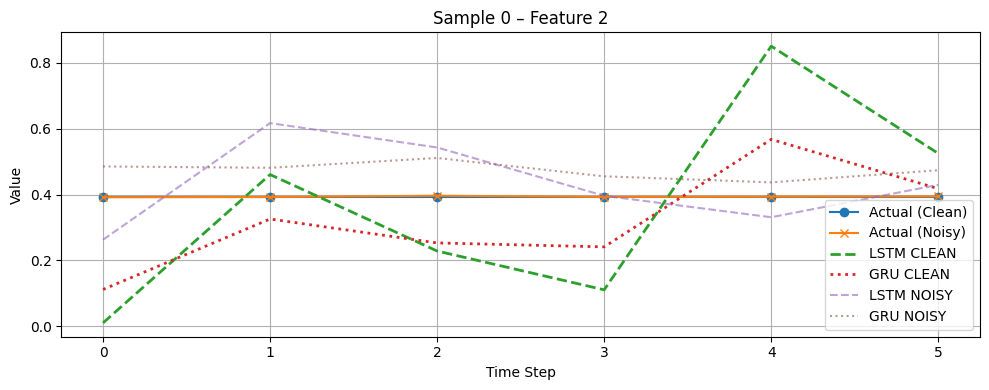

/tmp/ipython-input-38-3107350804.py:80: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


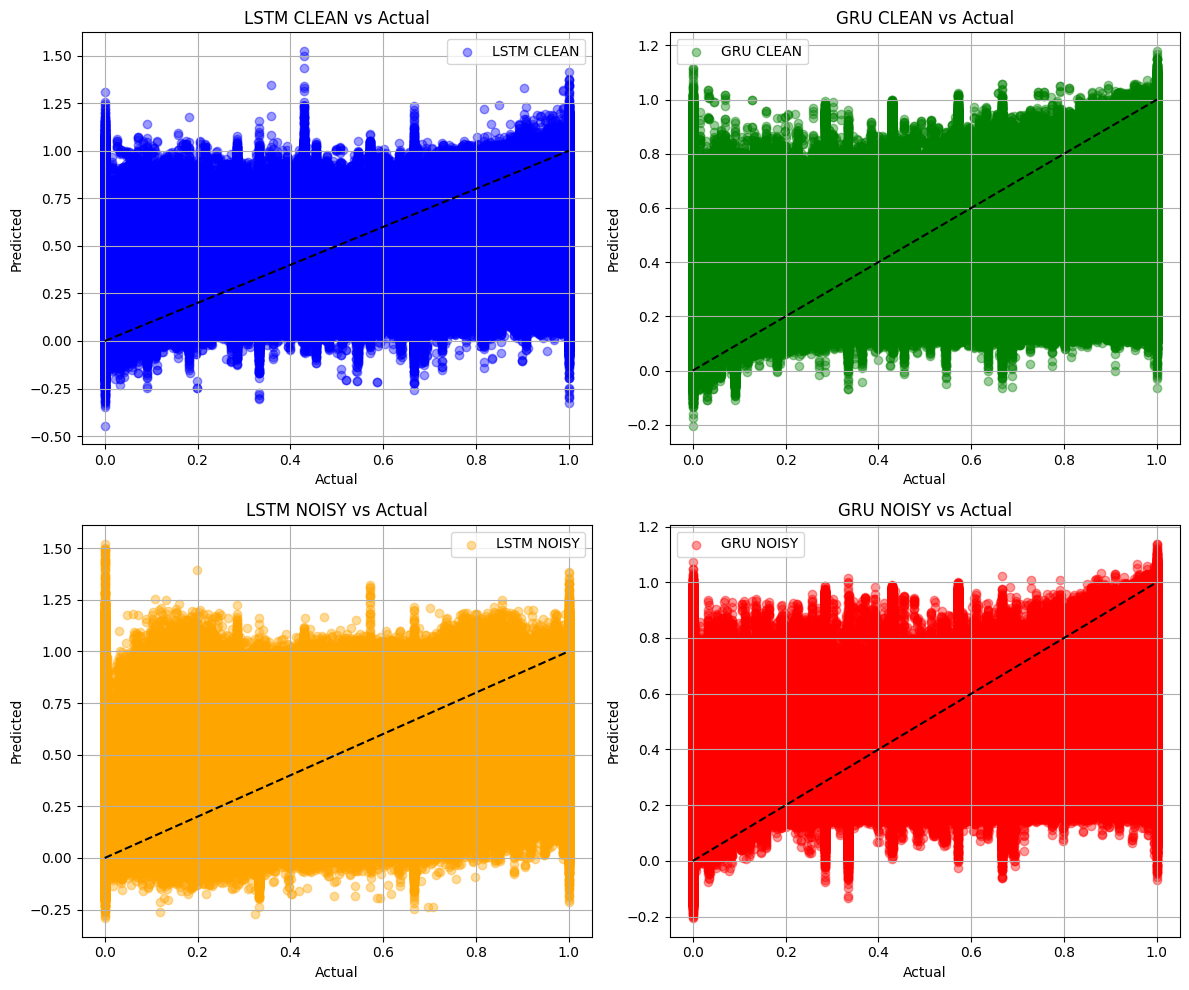

/tmp/ipython-input-38-3107350804.py:92: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors.values(), labels=errors.keys(), showmeans=True)


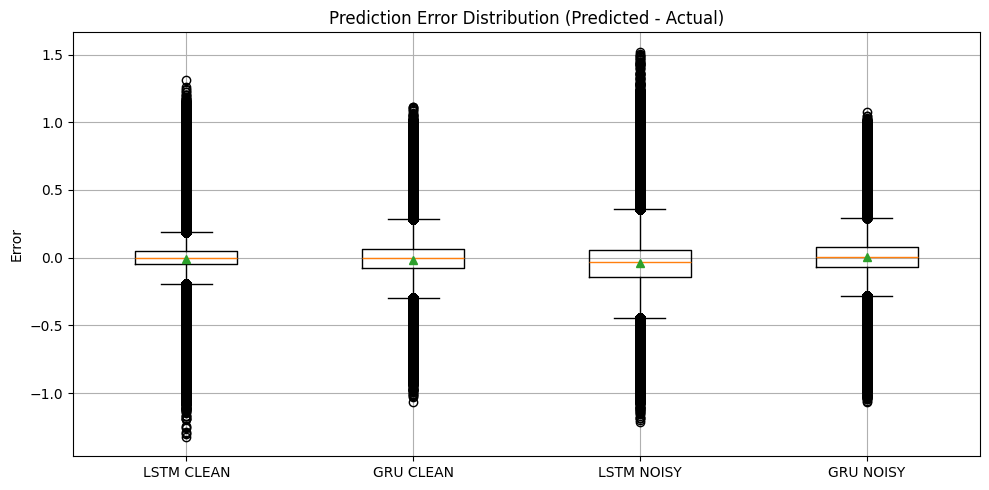

In [ ]:
visualize_predictions(y_test_clean, y_test_noisy, preds, output_seq_len=6, num_features=19)
